### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading csv file

In [2]:
df= pd.read_csv('heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Extracting information about the dataset

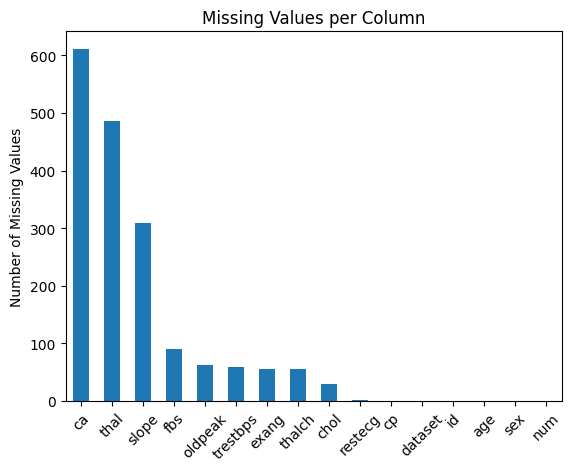

In [3]:
# df.info()
missing = df.isna().sum()

plt.figure()
missing.sort_values(ascending=False).plot(kind='bar')
plt.title("Missing Values per Column")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.show()

### Data Cleaning

In [4]:
df.drop(['id','dataset','ca','thal','slope'],axis=1,inplace= True)
df = df.rename(columns={'cp': 'Chest pain', 'trestbps': 'Resting blood pressure','chol':'Serum cholesterol','fbs':'Fasting blood sugar','restecg':'Resting ECG','thalch':'Maximum heart rate','exang':'Exercise induced angina','num':'Heart disease'})

### Binary encoding

In [5]:
df['sex']= df['sex'].map({'Female':0,'Male':1})
df['Fasting blood sugar']= df['Fasting blood sugar'].astype(float)
df['Exercise induced angina']= df['Exercise induced angina'].astype(float)
df['Heart disease'] = df['Heart disease'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
df.head()

,age,sex,Chest pain,Resting blood pressure,Serum cholesterol,Fasting blood sugar,Resting ECG,Maximum heart rate,Exercise induced angina,oldpeak,Heart disease
0,63,1,typical angina,145.0,233.0,1.0,lv hypertrophy,150.0,0.0,2.3,0
1,67,1,asymptomatic,160.0,286.0,0.0,lv hypertrophy,108.0,1.0,1.5,1
2,67,1,asymptomatic,120.0,229.0,0.0,lv hypertrophy,129.0,1.0,2.6,1
3,37,1,non-anginal,130.0,250.0,0.0,normal,187.0,0.0,3.5,0
4,41,0,atypical angina,130.0,204.0,0.0,lv hypertrophy,172.0,0.0,1.4,0


### Correlation Heatmap

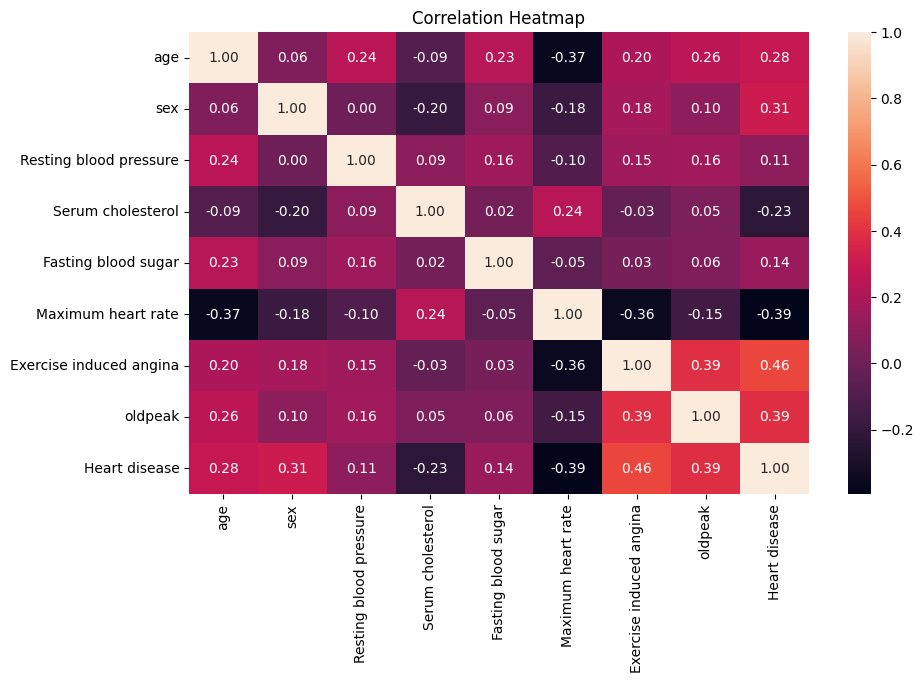

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Train test split

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Heart disease', axis=1)
y = df['Heart disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Handling NaN values 

In [9]:
from sklearn.impute import SimpleImputer
numerical_cols = ['Resting blood pressure','Serum cholesterol','Fasting blood sugar','Maximum heart rate','Exercise induced angina','oldpeak']
categorical_cols = ['Chest pain','Resting ECG']

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

### Encoding categorical values

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), categorical_cols)],remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=99)
rf.fit(X_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### Confusion matirx (Random Forest)

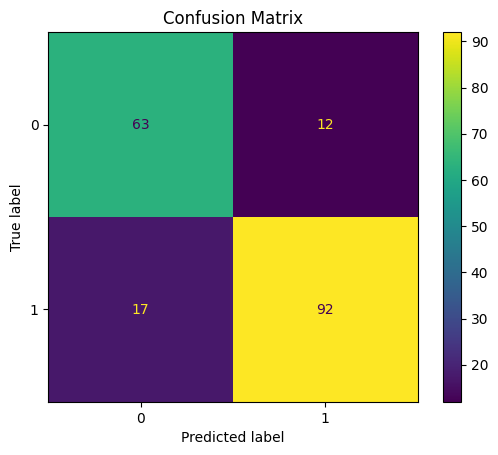

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_rf=rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

### Classification report (Random Forest)

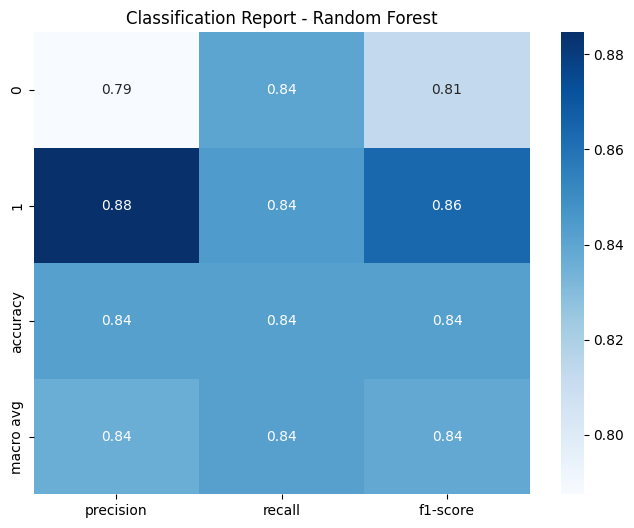

In [13]:
from sklearn.metrics import classification_report
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_df_rf = pd.DataFrame(report_rf).transpose()
report_df_rf = report_df_rf.drop(columns=['support'])
plt.figure(figsize=(8,6))
sns.heatmap(report_df_rf.iloc[:-1, :], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report - Random Forest")
plt.show()

### ROC AUC score (Random Forest)

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
y_prob_rf= rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob_rf)

0.9114984709480123

### Standard scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000,class_weight='balanced')
lr.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

### Confusion matrix (Logistic Regression)

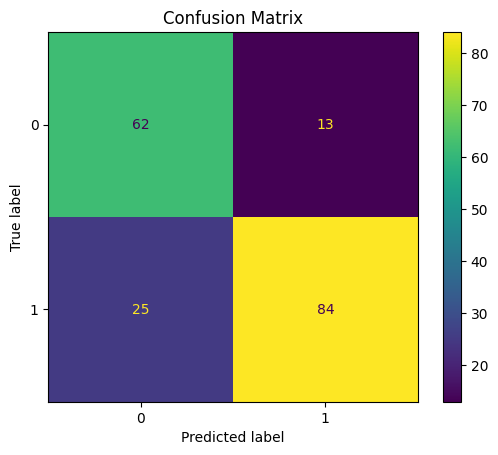

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred=lr.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

### Classification report (Logistic Regression)

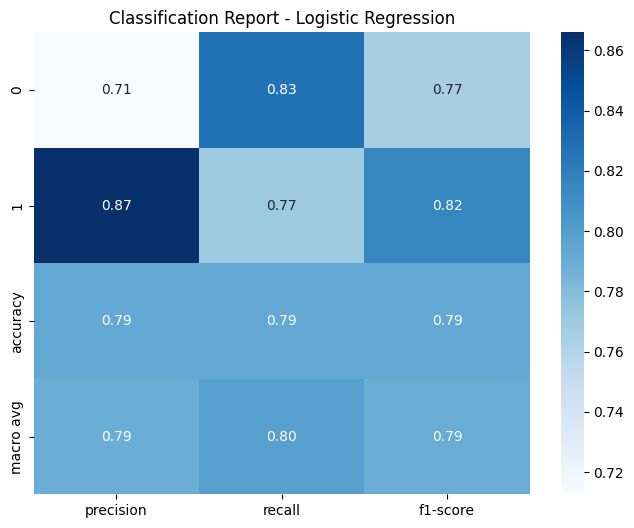

In [18]:
from sklearn.metrics import classification_report
report_lr = classification_report(y_test, y_pred, output_dict=True)
report_df_lr = pd.DataFrame(report_lr).transpose()
report_df_lr = report_df_lr.drop(columns=['support'])
plt.figure(figsize=(8,6))
sns.heatmap(report_df_lr.iloc[:-1, :], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report - Logistic Regression")
plt.show()

### ROC AUC score (Logistic Regression)

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
y_prob= lr.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_prob)

0.8863608562691131

### Compairing AUC score Random Forest Classifier and Logistic Regression

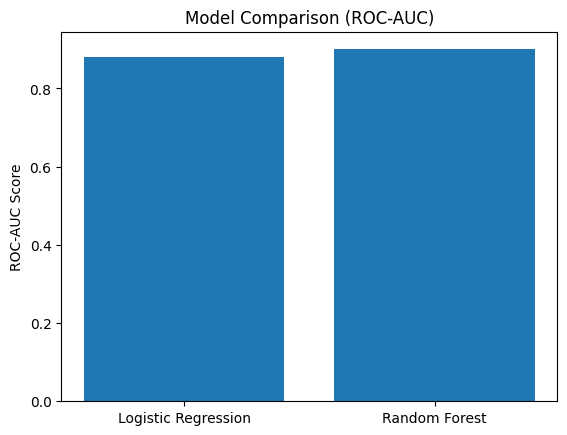

In [20]:
models = ["Logistic Regression", "Random Forest"]
auc_scores = [0.88, 0.90]

plt.figure()
plt.bar(models, auc_scores)
plt.title("Model Comparison (ROC-AUC)")
plt.ylabel("ROC-AUC Score")
plt.show()

### ROC curve comparision (LogisticRegression and RandomForestClassifier)

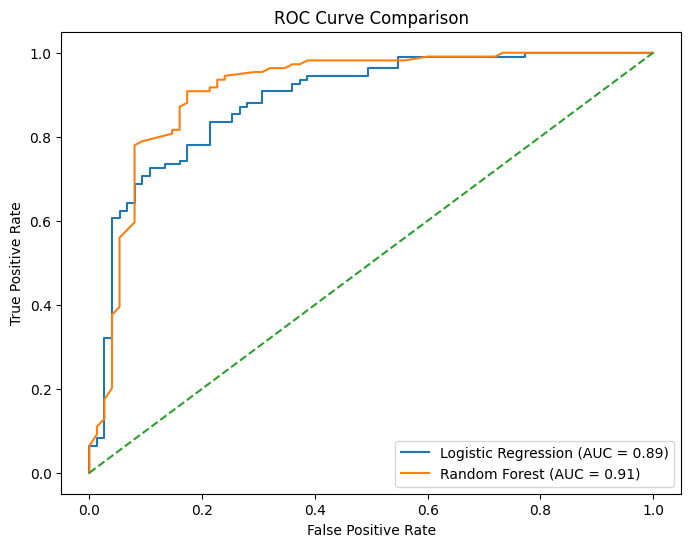

In [21]:
roc_rf = roc_auc_score(y_test, y_prob_rf)
roc_log = roc_auc_score(y_test, y_prob)

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_rf:.2f})')

plt.plot([0,1], [0,1], linestyle='--')  # Random classifier line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()